In [21]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms
import torch.optim as optim
# utils

from PIL import Image

from sklearn.model_selection import train_test_split


In [22]:
import torch
from glob import glob
import os
import random

# Global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "Brain_Data_Organised"  # Update the dataset path to point to the single folder
image_size = (224, 224)
num_classes = 2

# Get all image paths from both folders (normal and stroke)
normal_image_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_image_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))

# Combine the paths and shuffle them
image_paths = normal_image_paths + stroke_image_paths
random.shuffle(image_paths)

# Split the image paths into train and test sets
train_ratio = 0.8  # 80% for training, 20% for testing
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Check device
print(device)

# Print the number of images in each set for verification
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")


cpu
Total images: 2501
Training set size: 2000
Testing set size: 501


## Logistic Regression

Epoch 1:
Train Loss: 4.3941, Train Acc: 70.45%
Val Loss: 0.9129, Val Acc: 77.45%
--------------------------------------------------
Epoch 2:
Train Loss: 0.7138, Train Acc: 83.90%
Val Loss: 0.4696, Val Acc: 85.03%
--------------------------------------------------
Epoch 3:
Train Loss: 0.4494, Train Acc: 89.00%
Val Loss: 1.0393, Val Acc: 79.44%
--------------------------------------------------
Epoch 4:
Train Loss: 0.5011, Train Acc: 89.20%
Val Loss: 0.9942, Val Acc: 84.23%
--------------------------------------------------
Epoch 5:
Train Loss: 0.1691, Train Acc: 94.95%
Val Loss: 1.0225, Val Acc: 82.24%
--------------------------------------------------
Epoch 6:
Train Loss: 0.1649, Train Acc: 95.85%
Val Loss: 0.8537, Val Acc: 80.64%
--------------------------------------------------
Epoch 7:
Train Loss: 0.2831, Train Acc: 92.55%
Val Loss: 0.5438, Val Acc: 88.82%
--------------------------------------------------
Epoch 8:
Train Loss: 0.1947, Train Acc: 94.80%
Val Loss: 0.4275, Val Acc: 91

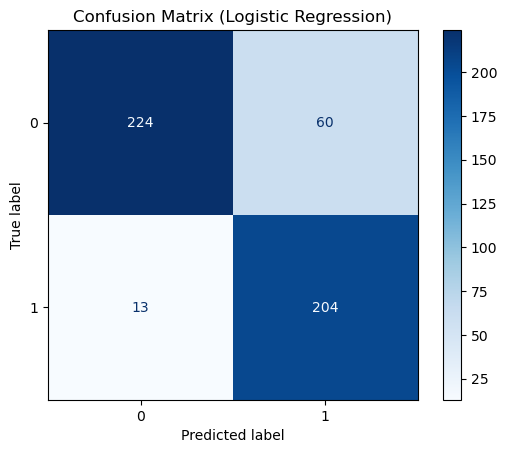

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ========================== Dataset Class ==========================
class BrainImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = 0 if "Normal" in img_path else 1  # 0: Normal, 1: Stroke
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ========================== Transforms ==========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ========================== Dataset & DataLoader ==========================
train_dataset = BrainImageDataset(train_paths, transform=transform)
test_dataset = BrainImageDataset(test_paths, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ========================== Logistic Regression Model ==========================
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.linear(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 3 * 224 * 224
num_classes = 2

model = LogisticRegressionModel(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ========================== Training & Evaluation ==========================
def train_epoch():
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(train_loader), correct / total

def eval_model():
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_preds, all_labels

# ========================== Training Loop ==========================
best_loss = float("inf")
for epoch in range(1, 11):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc, preds, labels = eval_model()

    print(f"Epoch {epoch}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    print("-" * 50)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "logreg_brain_best.pt")

# ========================== Evaluation Results ==========================
print("\nClassification Report:")
print(classification_report(labels, preds))

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


## Random Forest

Extracting Features:   0%|          | 0/2501 [00:00<?, ?it/s]

Extracting Features: 100%|██████████| 2501/2501 [00:31<00:00, 79.81it/s]



Total images: 2501
Training images: 2000
Testing images: 501

Training Random Forest Classifier...

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       311
           1       0.99      0.97      0.98       190

    accuracy                           0.99       501
   macro avg       0.99      0.99      0.99       501
weighted avg       0.99      0.99      0.99       501



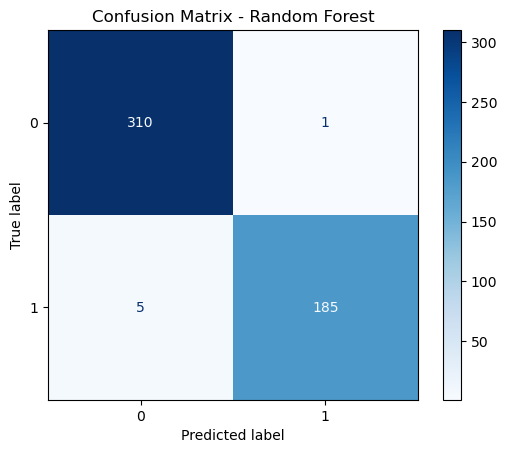

In [ ]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

# ========================== Configuration ==========================
dataset_path = "Brain_Data_Organised"
image_size = (224, 224)
num_classes = 2

# ========================== Image Paths ==========================
normal_image_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_image_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))

image_paths = normal_image_paths + stroke_image_paths
random.shuffle(image_paths)

# ========================== Labels ==========================
def get_label(path):
    return 0 if "Normal" in path else 1

labels = [get_label(p) for p in image_paths]

# ========================== Transform ==========================
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# ========================== Feature Extraction ==========================
def extract_features(image_paths):
    features = []
    for path in tqdm(image_paths, desc="Extracting Features"):
        image = Image.open(path).convert("RGB")
        image = transform(image)
        image = image.view(-1).numpy()  # Flatten to 1D
        features.append(image)
    return np.array(features)

# ========================== Split Data ==========================
X = extract_features(image_paths)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTotal images: {len(image_paths)}")
print(f"Training images: {len(X_train)}")
print(f"Testing images: {len(X_test)}")

# ========================== Train Random Forest ==========================
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ========================== Evaluation ==========================
y_pred = rf_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()


## Decision Tree

Extracting Features: 100%|██████████| 2501/2501 [00:34<00:00, 71.75it/s]



Total images: 2501
Training images: 2000
Testing images: 501

Training Decision Tree Classifier...

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       311
           1       0.91      0.91      0.91       190

    accuracy                           0.93       501
   macro avg       0.93      0.93      0.93       501
weighted avg       0.93      0.93      0.93       501



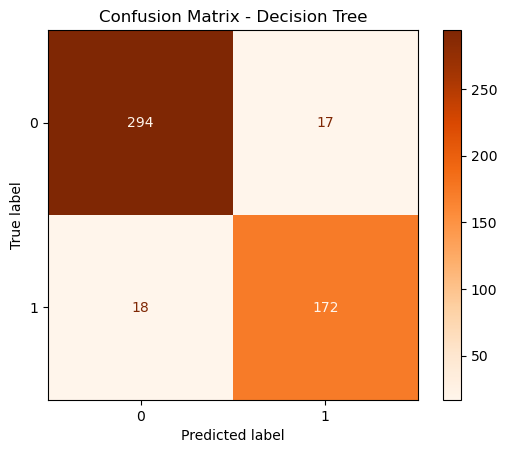

In [32]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

# ========================== Configuration ==========================
dataset_path = "Brain_Data_Organised"
image_size = (224, 224)
num_classes = 2

# ========================== Image Paths ==========================
normal_image_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_image_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))

image_paths = normal_image_paths + stroke_image_paths
random.shuffle(image_paths)

# ========================== Labels ==========================
def get_label(path):
    return 0 if "Normal" in path else 1

labels = [get_label(p) for p in image_paths]

# ========================== Transform ==========================
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# ========================== Feature Extraction ==========================
def extract_features(image_paths):
    features = []
    for path in tqdm(image_paths, desc="Extracting Features"):
        image = Image.open(path).convert("RGB")
        image = transform(image)
        image = image.view(-1).numpy()  # Flatten to 1D
        features.append(image)
    return np.array(features)

# ========================== Split Data ==========================
X = extract_features(image_paths)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTotal images: {len(image_paths)}")
print(f"Training images: {len(X_train)}")
print(f"Testing images: {len(X_test)}")

# ========================== Train Decision Tree ==========================
print("\nTraining Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# ========================== Evaluation ==========================
y_pred = dt_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - Decision Tree")
plt.show()
